Import Required Libraries

In [1]:
import pandas as pd
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline
import itertools
import warnings
warnings.filterwarnings("ignore")
import datetime
import math
from prophet import Prophet


Import the Data

In [2]:
#df_all = pd.read_csv('C:/Users/priygupta/BYOP/CPG_Master_data_Set.csv', index_col=3)
df_all = pd.read_csv('C:/Users/priygupta/BYOP/CPG_Master_data_Set.csv')
print(df_all.head())

   Invoice  Product_Code  Quantity InvoiceDate InvoiceDate_timeStamp  Price  \
0    89058       7259395         3  20-04-2019      20-04-2019 06:02     62   
1    89058         10557         5  20-04-2019      20-04-2019 06:02     37   
2    89058       2733507         3  20-04-2019      20-04-2019 06:02     48   
3    89058       5200349         5  20-04-2019      20-04-2019 06:02    100   
4    89058        715497         3  20-04-2019      20-04-2019 06:02     91   

   Customer_ID Country  Pack_Size_Code  In_Store_Promotion_Flag  \
0        38055     USA               3                        0   
1        38055     USA               3                        1   
2        38055     USA               1                        1   
3        38055     USA               4                        1   
4        38055     USA               2                        1   

   Online_Promotion_Flag  Shelf_Space_Code  
0                      0                 3  
1                      0        

Format the date data

In [3]:
'''
df_all.index = pd.to_datetime(df_all.index,
                          format='%d-%m-%Y')
df_all = df_all.sort_index(ascending=True)
print(df_all.head()) 
'''
df_all['InvoiceDate'] = pd.to_datetime(df_all['InvoiceDate'],
                          format='%d-%m-%Y')
#df_all = df_all.sort_index(ascending=True)
print(df_all.head()) 

   Invoice  Product_Code  Quantity InvoiceDate InvoiceDate_timeStamp  Price  \
0    89058       7259395         3  2019-04-20      20-04-2019 06:02     62   
1    89058         10557         5  2019-04-20      20-04-2019 06:02     37   
2    89058       2733507         3  2019-04-20      20-04-2019 06:02     48   
3    89058       5200349         5  2019-04-20      20-04-2019 06:02    100   
4    89058        715497         3  2019-04-20      20-04-2019 06:02     91   

   Customer_ID Country  Pack_Size_Code  In_Store_Promotion_Flag  \
0        38055     USA               3                        0   
1        38055     USA               3                        1   
2        38055     USA               1                        1   
3        38055     USA               4                        1   
4        38055     USA               2                        1   

   Online_Promotion_Flag  Shelf_Space_Code  
0                      0                 3  
1                      0        

Create a revenue column

In [4]:
df_all['Revenue'] = df_all['Price'] * df_all['Quantity']
print(df_all.head())

   Invoice  Product_Code  Quantity InvoiceDate InvoiceDate_timeStamp  Price  \
0    89058       7259395         3  2019-04-20      20-04-2019 06:02     62   
1    89058         10557         5  2019-04-20      20-04-2019 06:02     37   
2    89058       2733507         3  2019-04-20      20-04-2019 06:02     48   
3    89058       5200349         5  2019-04-20      20-04-2019 06:02    100   
4    89058        715497         3  2019-04-20      20-04-2019 06:02     91   

   Customer_ID Country  Pack_Size_Code  In_Store_Promotion_Flag  \
0        38055     USA               3                        0   
1        38055     USA               3                        1   
2        38055     USA               1                        1   
3        38055     USA               4                        1   
4        38055     USA               2                        1   

   Online_Promotion_Flag  Shelf_Space_Code  Revenue  
0                      0                 3      186  
1             

Data Details 


In [5]:
df_all.shape
df_all.info()
df_all.describe(include='all').T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803000 entries, 0 to 802999
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   Invoice                  803000 non-null  int64         
 1   Product_Code             803000 non-null  int64         
 2   Quantity                 803000 non-null  int64         
 3   InvoiceDate              803000 non-null  datetime64[ns]
 4   InvoiceDate_timeStamp    803000 non-null  object        
 5   Price                    803000 non-null  int64         
 6   Customer_ID              803000 non-null  int64         
 7   Country                  803000 non-null  object        
 8   Pack_Size_Code           803000 non-null  int64         
 9   In_Store_Promotion_Flag  803000 non-null  int64         
 10  Online_Promotion_Flag    803000 non-null  int64         
 11  Shelf_Space_Code         803000 non-null  int64         
 12  Revenue         

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
Invoice,803000.0,NaN,NaN,NaN,NaT,NaT,54833.860039,26012.613808,10001.0,32284.0,54635.0,77281.0,99998.0
Product_Code,803000.0,NaN,NaN,NaN,NaT,NaT,1887418.878384,2535254.119949,10557.0,73186.0,669238.0,3611064.0,8991517.0
Quantity,803000.0,NaN,NaN,NaN,NaT,NaT,3.501186,1.381731,1.0,3.0,4.0,4.0,6.0
InvoiceDate,803000,1325,2022-11-16 00:00:00,1882,2019-04-20,2022-12-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
InvoiceDate_timeStamp,803000,32350,22-09-2021 02:52,140,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Price,803000.0,NaN,NaN,NaN,NaT,NaT,51.398333,29.440525,2.0,23.0,55.0,78.0,100.0
Customer_ID,803000.0,NaN,NaN,NaN,NaT,NaT,54227.347229,26305.655558,10125.0,31027.0,53618.0,77549.0,99988.0
Country,803000,1,USA,803000,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pack_Size_Code,803000.0,NaN,NaN,NaN,NaT,NaT,2.50002,1.117259,1.0,2.0,2.0,3.0,4.0
In_Store_Promotion_Flag,803000.0,NaN,NaN,NaN,NaT,NaT,0.499416,0.5,0.0,0.0,0.0,1.0,1.0


Identify the distinct Product and pack size combinations 

In [6]:
product_list = df_all['Product_Code'].tolist()
pack_size_list = df_all['Pack_Size_Code'].tolist()
product_list = list(set(product_list))
pack_size_list = list(set(pack_size_list))
product_pack_size_combination = {  
    'Product': product_list,
    'pack_size': pack_size_list}


All_combinations = [dict(zip(product_pack_size_combination.keys(), v)) for v in itertools.product(*product_pack_size_combination.values())]
print(len(All_combinations))
print(All_combinations)


160
[{'Product': 7259395, 'pack_size': 1}, {'Product': 7259395, 'pack_size': 2}, {'Product': 7259395, 'pack_size': 3}, {'Product': 7259395, 'pack_size': 4}, {'Product': 4617477, 'pack_size': 1}, {'Product': 4617477, 'pack_size': 2}, {'Product': 4617477, 'pack_size': 3}, {'Product': 4617477, 'pack_size': 4}, {'Product': 5610377, 'pack_size': 1}, {'Product': 5610377, 'pack_size': 2}, {'Product': 5610377, 'pack_size': 3}, {'Product': 5610377, 'pack_size': 4}, {'Product': 13579, 'pack_size': 1}, {'Product': 13579, 'pack_size': 2}, {'Product': 13579, 'pack_size': 3}, {'Product': 13579, 'pack_size': 4}, {'Product': 6417803, 'pack_size': 1}, {'Product': 6417803, 'pack_size': 2}, {'Product': 6417803, 'pack_size': 3}, {'Product': 6417803, 'pack_size': 4}, {'Product': 211214, 'pack_size': 1}, {'Product': 211214, 'pack_size': 2}, {'Product': 211214, 'pack_size': 3}, {'Product': 211214, 'pack_size': 4}, {'Product': 673422, 'pack_size': 1}, {'Product': 673422, 'pack_size': 2}, {'Product': 673422, '

Create different Dataframes for all the product and pack sizes combinations

In [7]:
pro_id_list = []
pack_size_list = []
df_name = []
shape_df = []
counter = 1
for param in All_combinations:
    #identify the filting Parameter
    dic = dict(param)
    df_all_filtered = df_all[(df_all['Product_Code'] == dic['Product']) & (df_all['Pack_Size_Code'] == dic['pack_size'])]
    #print(df_all_filtered.shape)
    #print(df_all_filtered)
    i1 = str('df'+str(counter))
    exec('{} = df_all_filtered'.format(i1))
    counter = counter+1
    pro_id_list.append(dic['Product'])
    pack_size_list.append(dic['pack_size'])
    df_name.append(i1)
    shape_df.append(df_all_filtered.shape)
    
    


In [8]:
df_details = pd.DataFrame(list(zip(pro_id_list,pack_size_list,df_name,shape_df)),
                         columns = ['Product_List','Pack_Size','df_name','DataFrame_shape'])

print(df_details)

     Product_List  Pack_Size df_name DataFrame_shape
0         7259395          1     df1      (5041, 13)
1         7259395          2     df2      (5141, 13)
2         7259395          3     df3      (4846, 13)
3         7259395          4     df4      (4961, 13)
4         4617477          1     df5      (5022, 13)
..            ...        ...     ...             ...
155         46327          4   df156      (4986, 13)
156        897016          1   df157      (4954, 13)
157        897016          2   df158      (5047, 13)
158        897016          3   df159      (4927, 13)
159        897016          4   df160      (4945, 13)

[160 rows x 4 columns]


Remove Columns with Null data

In [9]:
df1.shape
df1 = df1.dropna(axis=0)
df1.shape
df1.head()

,Invoice,Product_Code,Quantity,InvoiceDate,InvoiceDate_timeStamp,Price,Customer_ID,Country,Pack_Size_Code,In_Store_Promotion_Flag,Online_Promotion_Flag,Shelf_Space_Code,Revenue
120,73868,7259395,2,2019-04-20,20-04-2019 11:13,66,23581,USA,1,1,0,1,132
316,10131,7259395,2,2019-04-21,20-04-2019 21:06,66,69340,USA,1,1,0,2,132
537,39427,7259395,1,2019-04-21,21-04-2019 06:59,66,11720,USA,1,0,0,2,66
765,11375,7259395,1,2019-04-22,21-04-2019 16:28,66,15806,USA,1,1,1,2,66
1251,59121,7259395,1,2019-04-23,22-04-2019 21:53,66,46611,USA,1,1,1,2,66


In [10]:
df1_training = df1[['InvoiceDate','Revenue']]
df1_training = df1_training.groupby('InvoiceDate')[['Revenue']].sum()
df1_training.reset_index(inplace=True)
print(df1_training)

     InvoiceDate  Revenue
0     2019-04-20      132
1     2019-04-21      198
2     2019-04-22       66
3     2019-04-23      264
4     2019-04-24      132
...          ...      ...
1253  2022-11-29      660
1254  2022-11-30     1320
1255  2022-12-02      660
1256  2022-12-03      924
1257  2022-12-04     1980

[1258 rows x 2 columns]


In [20]:
'''
float_array = df1_training['Revenue'].values.astype(float).reshape(-1,1)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(float_array)
df1_training['Scaled']=scaled_array

print(df1_training)
'''

       InvoiceDate  Revenue  Scaled
120     2019-04-20      132     0.5
316     2019-04-21      132     0.5
537     2019-04-21       66     0.0
765     2019-04-22       66     0.0
1251    2019-04-23       66     0.0
...            ...      ...     ...
802409  2022-12-04      132     0.5
802494  2022-12-04      132     0.5
802664  2022-12-04       66     0.0
802794  2022-12-04      198     1.0
802867  2022-12-04      198     1.0

[5041 rows x 3 columns]


In [22]:
values = df1_training['Revenue'].values.astype('float32').reshape(-1,1)

scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(values)
df1_training['Scaled']=scaled

print(df1_training)

     InvoiceDate  Revenue   Scaled
0     2019-04-20      132  1.03125
1     2019-04-21      198  1.06250
2     2019-04-22       66  1.00000
3     2019-04-23      264  1.09375
4     2019-04-24      132  1.03125
...          ...      ...      ...
1253  2022-11-29      660  1.28125
1254  2022-11-30     1320  1.59375
1255  2022-12-02      660  1.28125
1256  2022-12-03      924  1.40625
1257  2022-12-04     1980  1.90625

[1258 rows x 3 columns]


In [24]:
df1_training_prophet = df1_training[['InvoiceDate','Scaled']]
df1_training_prophet.columns =  ['ds','y']
print(df1_training_prophet)

             ds        y
0    2019-04-20  1.03125
1    2019-04-21  1.06250
2    2019-04-22  1.00000
3    2019-04-23  1.09375
4    2019-04-24  1.03125
...         ...      ...
1253 2022-11-29  1.28125
1254 2022-11-30  1.59375
1255 2022-12-02  1.28125
1256 2022-12-03  1.40625
1257 2022-12-04  1.90625

[1258 rows x 2 columns]


Train and Test Split

In [25]:
 
test_percentage = .2
test_size = round(df1_training_prophet.shape[0] * test_percentage )


df_train = df1_training_prophet[:-test_size]
df_test = df1_training_prophet[-test_size:]

#df_train = df_train[['ds','y','cap']]
#df_test = df_test[['ds','y','cap']]

print(df_train.shape)

print(df_test.shape)


(1006, 2)
(252, 2)


Function to Calculate MAPE

In [26]:
def calculate_mape(actual,predicted) -> float:
  
    # Convert actual and predicted
    # to numpy array data type if not already
    if not all([isinstance(actual, np.ndarray),isinstance(predicted, np.ndarray)]):
        actual, predicted = np.array(actual),np.array(predicted)
  
    # Calculate the MAPE value and return
    return round(np.mean(np.abs((actual - predicted) / actual)) * 100, 2)


16:39:09 - cmdstanpy - INFO - Chain [1] start processing
16:39:09 - cmdstanpy - INFO - Chain [1] done processing
16:39:10 - cmdstanpy - INFO - Chain [1] start processing


10.54648678432377
0.16702602176779796


16:39:10 - cmdstanpy - INFO - Chain [1] done processing
16:39:11 - cmdstanpy - INFO - Chain [1] start processing


10.491058398790006
0.16646646778034266


16:39:11 - cmdstanpy - INFO - Chain [1] done processing
16:39:12 - cmdstanpy - INFO - Chain [1] start processing


10.510077333755742
0.16653069923160205


16:39:12 - cmdstanpy - INFO - Chain [1] done processing
16:39:13 - cmdstanpy - INFO - Chain [1] start processing


10.50778626534415
0.16650483110664016


16:39:13 - cmdstanpy - INFO - Chain [1] done processing
16:39:14 - cmdstanpy - INFO - Chain [1] start processing


10.098191465449133
0.17098819569700494


16:39:14 - cmdstanpy - INFO - Chain [1] done processing
16:39:15 - cmdstanpy - INFO - Chain [1] start processing


10.08339243232233
0.1701268701991996


16:39:15 - cmdstanpy - INFO - Chain [1] done processing
16:39:16 - cmdstanpy - INFO - Chain [1] start processing


10.084181122325383
0.17054829765449916


16:39:16 - cmdstanpy - INFO - Chain [1] done processing
16:39:17 - cmdstanpy - INFO - Chain [1] start processing


10.0848730510212
0.17067069957014472


16:39:17 - cmdstanpy - INFO - Chain [1] done processing
16:39:18 - cmdstanpy - INFO - Chain [1] start processing


10.14921784188507
0.1668596638587076


16:39:18 - cmdstanpy - INFO - Chain [1] done processing
16:39:19 - cmdstanpy - INFO - Chain [1] start processing


10.0993362866685
0.16695443858957215


16:39:19 - cmdstanpy - INFO - Chain [1] done processing
16:39:20 - cmdstanpy - INFO - Chain [1] start processing


10.093030785665903
0.16715561098801207


16:39:20 - cmdstanpy - INFO - Chain [1] done processing
16:39:21 - cmdstanpy - INFO - Chain [1] start processing


10.092889318858402
0.1671117638079745


16:39:21 - cmdstanpy - INFO - Chain [1] done processing


10.246132698647385
0.16554621596572638


16:39:22 - cmdstanpy - INFO - Chain [1] start processing
16:39:23 - cmdstanpy - INFO - Chain [1] done processing


10.021201278400937
0.16785063466389413


16:39:24 - cmdstanpy - INFO - Chain [1] start processing
16:39:24 - cmdstanpy - INFO - Chain [1] done processing


10.022023941663123
0.1679465286068724


16:39:26 - cmdstanpy - INFO - Chain [1] start processing
16:39:26 - cmdstanpy - INFO - Chain [1] done processing


10.0212252726156
0.1677950469835157


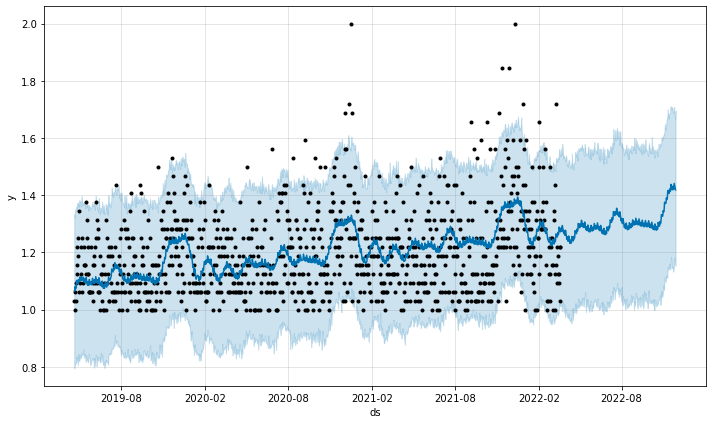

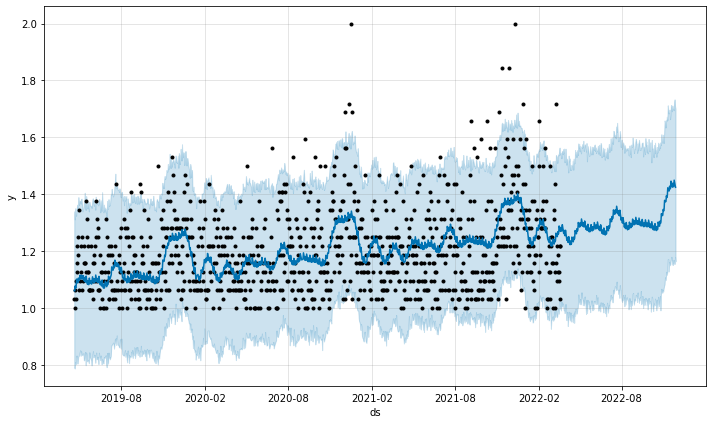

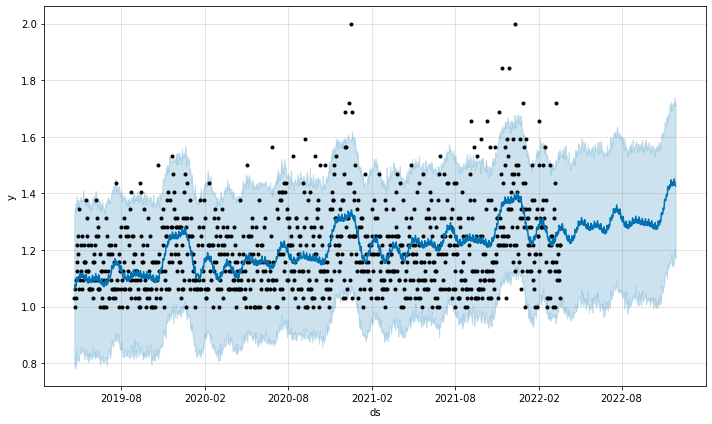

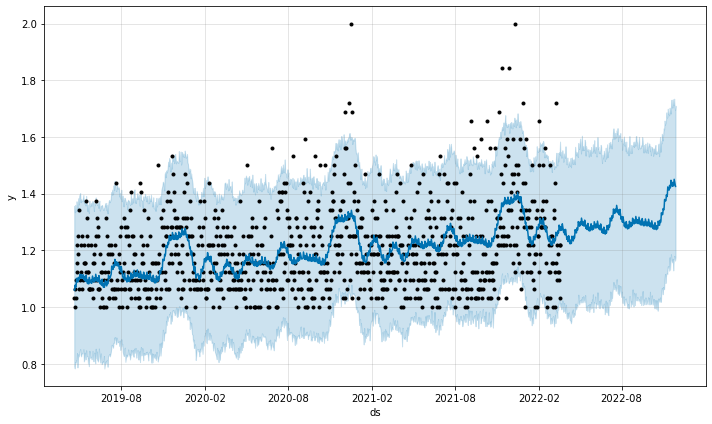

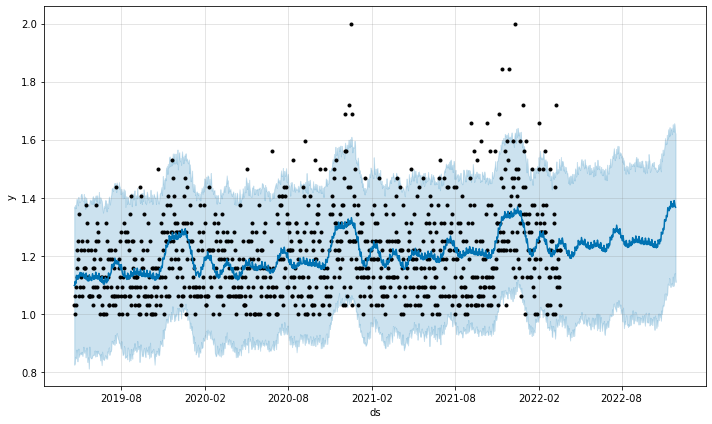

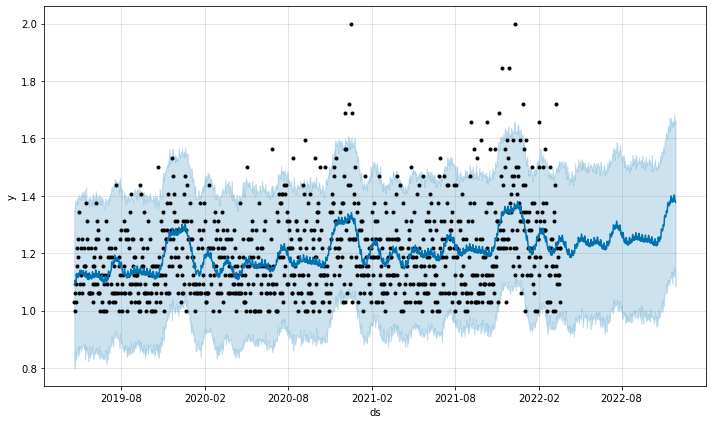

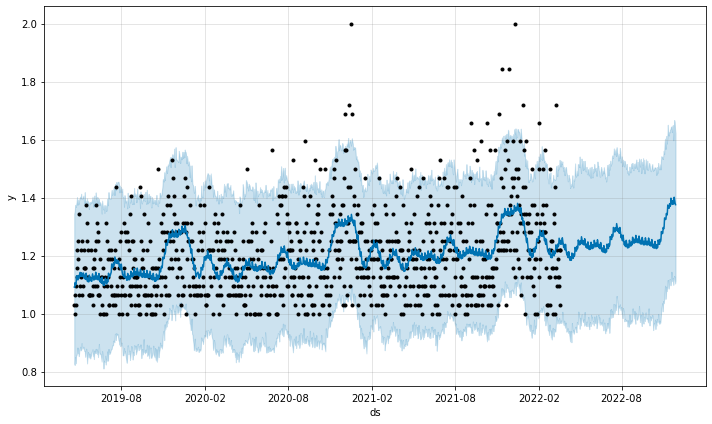

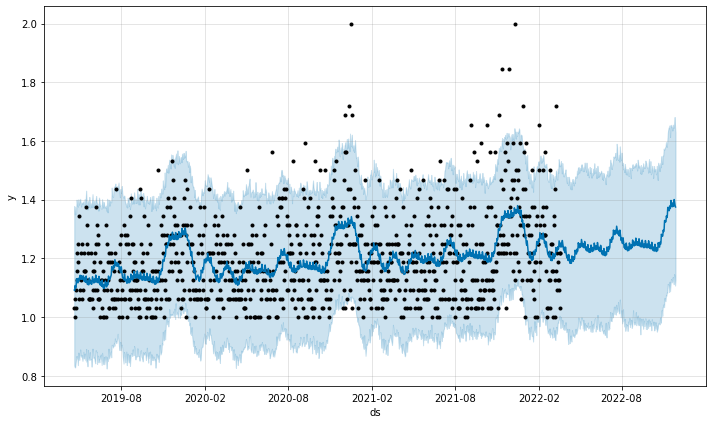

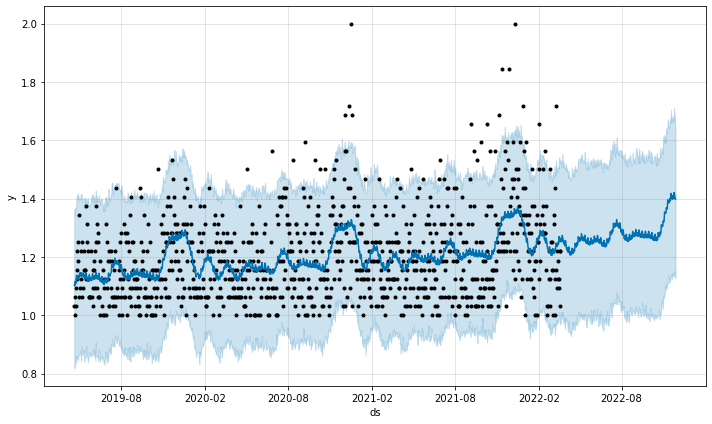

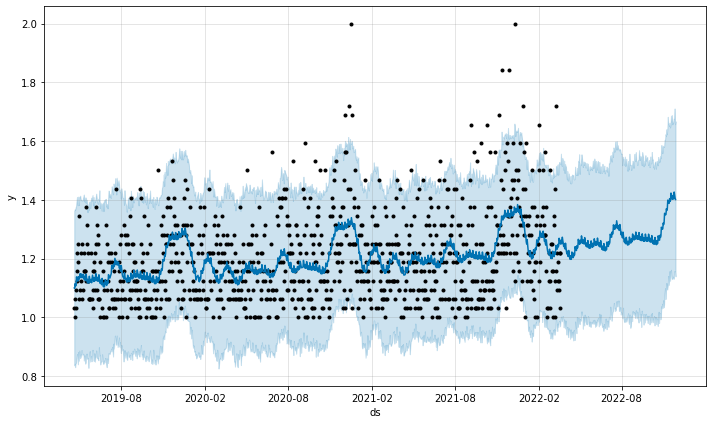

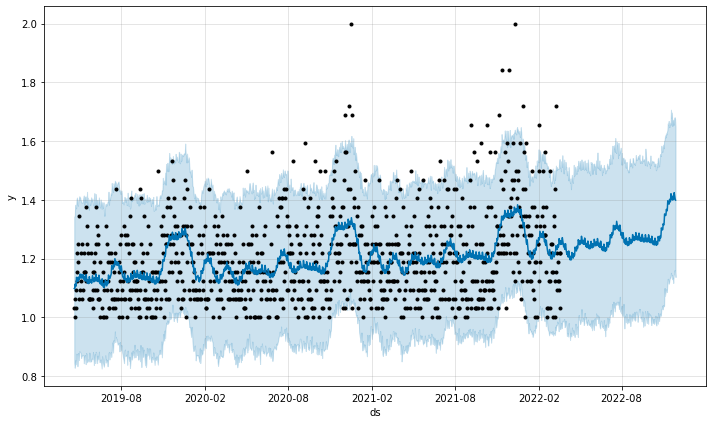

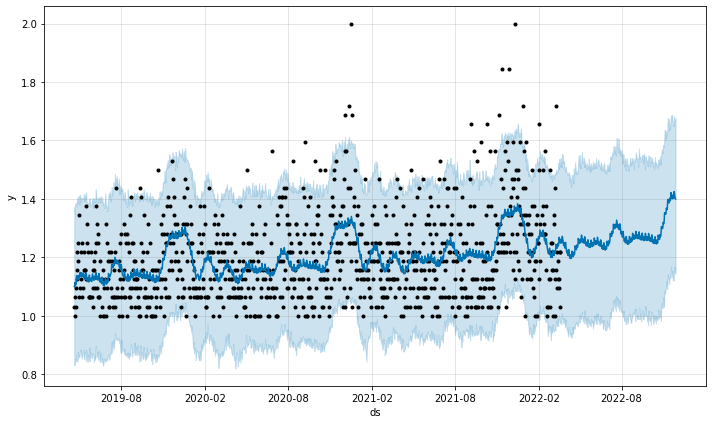

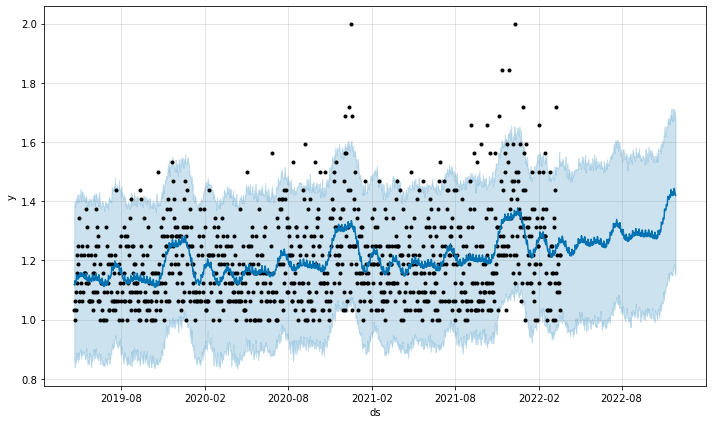

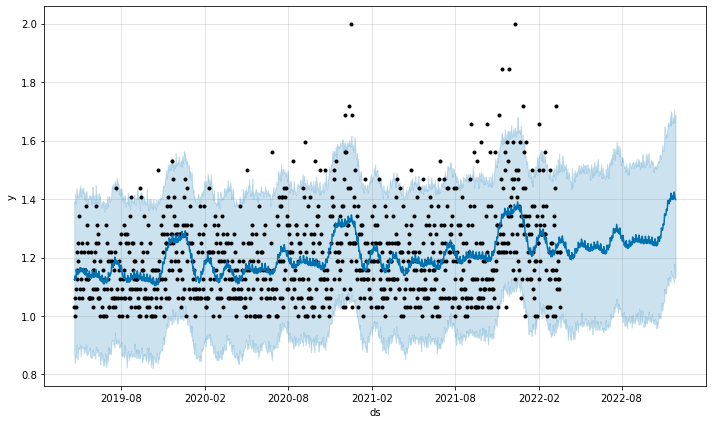

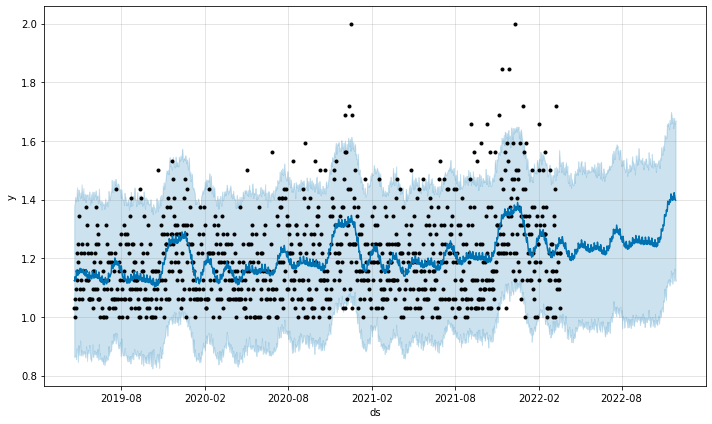

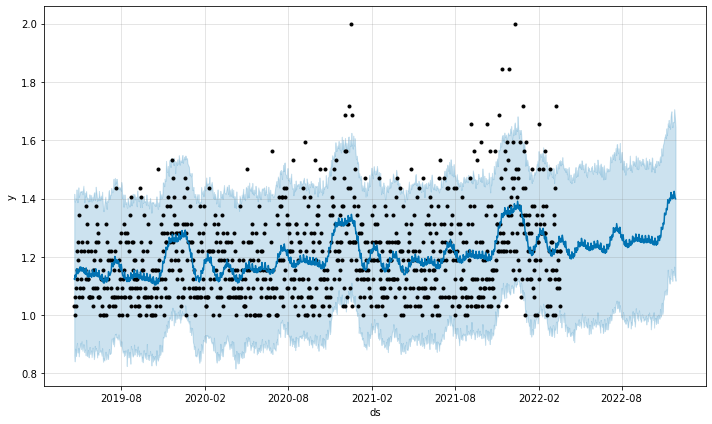

In [38]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

mape = []
rmse = []
for params in all_params:
    m = Prophet(**params,interval_width=0.95).fit(df_train)
    future = m.make_future_dataframe(periods=test_size)
    forecast_1 = m.predict(future)
    forecast_df = forecast_1[['ds', 'yhat']].tail(test_size)
    y_actual = df_test['y']
    y_predicted = forecast_df['yhat']
    

    
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 

    RMSE = math.sqrt(MSE)
    
    def calculate_mape(actual, pred): 
        actual, pred = np.array(actual), np.array(pred)
        return np.mean(np.abs((actual - pred) / actual)) * 100
    
    mape_value = calculate_mape(y_actual,y_predicted)
    print(mape_value)
    print(RMSE)
    mape.append(mape_value)
    rmse.append(RMSE)
    

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
tuning_results['rmse'] = rmse
#print(tuning_results)


In [34]:
print(tuning_results)

    changepoint_prior_scale  seasonality_prior_scale       mape      rmse
0                     0.001                     0.01  10.546487  0.167026
1                     0.001                     0.10  10.491058  0.166466
2                     0.001                     1.00  10.510077  0.166531
3                     0.001                    10.00  10.507786  0.166505
4                     0.010                     0.01  10.098191  0.170988
5                     0.010                     0.10  10.083392  0.170127
6                     0.010                     1.00  10.084181  0.170548
7                     0.010                    10.00  10.084873  0.170671
8                     0.100                     0.01  10.149218  0.166860
9                     0.100                     0.10  10.099336  0.166954
10                    0.100                     1.00  10.093031  0.167156
11                    0.100                    10.00  10.092889  0.167112
12                    0.500           

In [54]:
m = Prophet(changepoint_prior_scale=0.500,seasonality_prior_scale=0.01,interval_width=0.95,yearly_seasonality=True).fit(df_train)
future = m.make_future_dataframe(periods=test_size)
forecast_1 = m.predict(future)
forecast_df = forecast_1[['ds', 'yhat']].tail(test_size)
y_actual = df_test['y']
y_predicted = forecast_df['yhat']


MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 

RMSE = math.sqrt(MSE)
    
def calculate_mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100
    
mape_value = calculate_mape(y_actual,y_predicted)



17:34:08 - cmdstanpy - INFO - Chain [1] start processing
17:34:08 - cmdstanpy - INFO - Chain [1] done processing


10.246132698647385
0.16554621596572638


In [60]:
print(mape_value)
print(RMSE)

10.246132698647385
0.16554621596572638


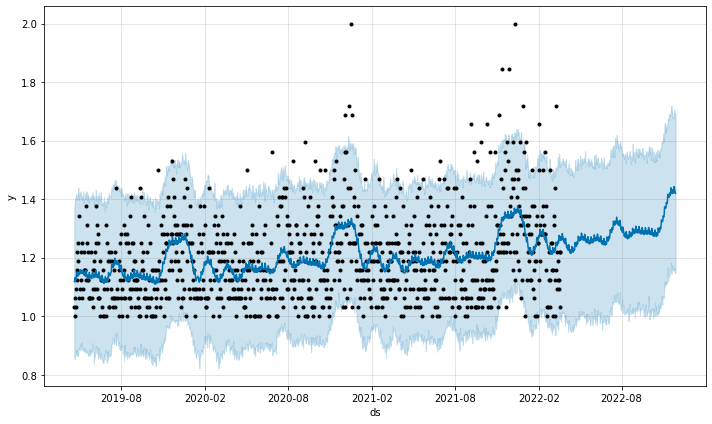

In [55]:
fig1 = m.plot(forecast_1, uncertainty=True)

In [56]:
float_array1 = forecast_df['yhat'].values.astype(float).reshape(-1,1)
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_array = min_max_scaler.fit_transform(float_array1)
inv_yhat = scaler.inverse_transform(float_array1)
forecast_df['inv_y_hat']=inv_yhat
print(forecast_df)

             ds      yhat    inv_y_hat
1006 2022-03-21  1.272015   640.496082
1007 2022-03-22  1.261226   617.709363
1008 2022-03-23  1.261445   618.171974
1009 2022-03-24  1.282377   662.380572
1010 2022-03-25  1.272482   641.482296
...         ...       ...          ...
1253 2022-11-23  1.421442   956.085890
1254 2022-11-24  1.442971  1001.554630
1255 2022-11-25  1.434098   982.815708
1256 2022-11-26  1.424187   961.882404
1257 2022-11-27  1.419680   952.364825

[252 rows x 3 columns]


In [57]:

float_array_test = df_test['y'].values.astype(float).reshape(-1,1)
#min_max_scaler = preprocessing.MinMaxScaler()
#scaled_array = min_max_scaler.fit_transform(float_array1)
inv_yhat_test = scaler.inverse_transform(float_array_test)
df_test['inv_y_test']=inv_yhat_test
print(df_test)

             ds        y   inv_y_test
1006 2022-03-21  1.21875   527.999984
1007 2022-03-22  1.06250   197.999994
1008 2022-03-23  1.40625   923.999972
1009 2022-03-24  1.21875   527.999984
1010 2022-03-25  1.40625   923.999972
...         ...      ...          ...
1253 2022-11-29  1.28125   659.999980
1254 2022-11-30  1.59375  1319.999961
1255 2022-12-02  1.28125   659.999980
1256 2022-12-03  1.40625   923.999972
1257 2022-12-04  1.90625  1979.999941

[252 rows x 3 columns]


In [58]:
df_forecast_actual = pd.merge(left = forecast_df,right =  df_test , how = 'left', left_on = 'ds',right_on = 'ds')


In [50]:
df_forecast_actual_compare = df_forecast_actual[['ds','inv_y_hat','inv_y_test']]
print(df_forecast_actual_compare)

            ds   inv_y_hat   inv_y_test
0   2022-03-21  622.930706   527.999984
1   2022-03-22  597.724305   197.999994
2   2022-03-23  597.068160   923.999972
3   2022-03-24  644.987421   527.999984
4   2022-03-25  620.943143   923.999972
..         ...         ...          ...
247 2022-11-23  912.898656  1385.999959
248 2022-11-24  963.005607  1187.999965
249 2022-11-25  942.147435   527.999984
250 2022-11-26  919.029986  1385.999959
251 2022-11-27  908.810783   659.999980

[252 rows x 3 columns]


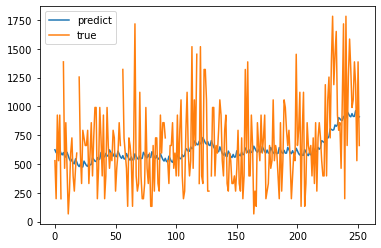

In [59]:
pyplot.plot(df_forecast_actual_compare['inv_y_hat'], label='predict')
pyplot.plot(df_forecast_actual_compare['inv_y_test'], label='true')
pyplot.legend()
pyplot.show()

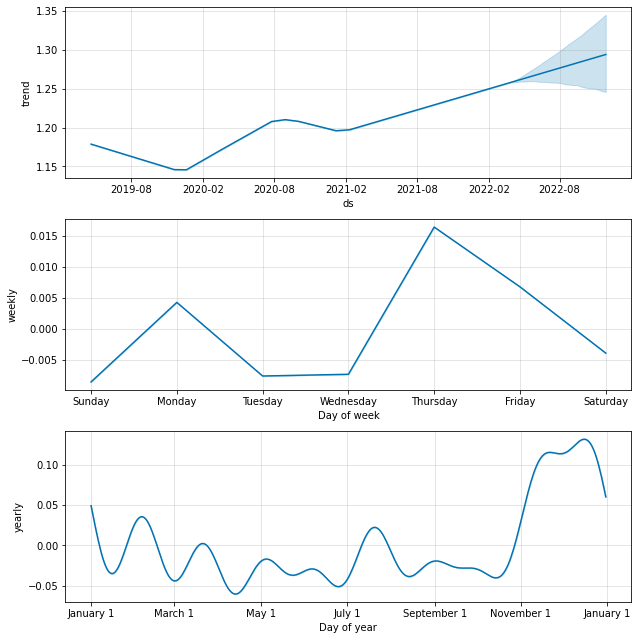

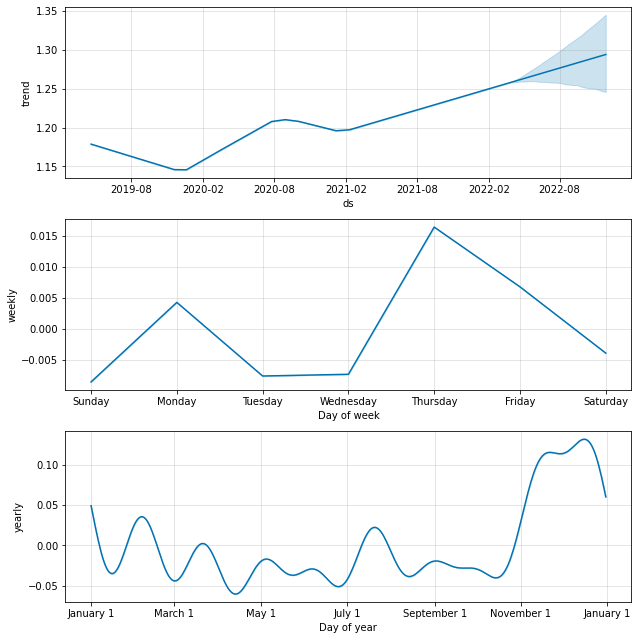

In [53]:
m.plot_components(forecast_1)

Multivariate Analysis

In [61]:
df1.head()

,Invoice,Product_Code,Quantity,InvoiceDate,InvoiceDate_timeStamp,Price,Customer_ID,Country,Pack_Size_Code,In_Store_Promotion_Flag,Online_Promotion_Flag,Shelf_Space_Code,Revenue
120,73868,7259395,2,2019-04-20,20-04-2019 11:13,66,23581,USA,1,1,0,1,132
316,10131,7259395,2,2019-04-21,20-04-2019 21:06,66,69340,USA,1,1,0,2,132
537,39427,7259395,1,2019-04-21,21-04-2019 06:59,66,11720,USA,1,0,0,2,66
765,11375,7259395,1,2019-04-22,21-04-2019 16:28,66,15806,USA,1,1,1,2,66
1251,59121,7259395,1,2019-04-23,22-04-2019 21:53,66,46611,USA,1,1,1,2,66


In [63]:
df1_training_multivariate = df1[['InvoiceDate','Revenue','Price','Quantity',]]
df1_training_multivariate = df1_training_multivariate.groupby('InvoiceDate')[['Revenue','Price','Quantity']].sum()
df1_training_multivariate.reset_index(inplace=True)
print(df1_training_multivariate)

     InvoiceDate  Revenue  Price  Quantity
0     2019-04-20      132     66         2
1     2019-04-21      198    132         3
2     2019-04-22       66     66         1
3     2019-04-23      264    198         4
4     2019-04-24      132     66         2
...          ...      ...    ...       ...
1253  2022-11-29      660    330        10
1254  2022-11-30     1320    528        20
1255  2022-12-02      660    330        10
1256  2022-12-03      924    528        14
1257  2022-12-04     1980    924        30

[1258 rows x 4 columns]


In [64]:
values = df1_training_multivariate['Revenue'].values.astype('float32').reshape(-1,1)

scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(values)
df1_training_multivariate['Scaled_Revenue']=scaled

print(df1_training_multivariate)

     InvoiceDate  Revenue  Price  Quantity  Scaled_Revenue
0     2019-04-20      132     66         2         1.03125
1     2019-04-21      198    132         3         1.06250
2     2019-04-22       66     66         1         1.00000
3     2019-04-23      264    198         4         1.09375
4     2019-04-24      132     66         2         1.03125
...          ...      ...    ...       ...             ...
1253  2022-11-29      660    330        10         1.28125
1254  2022-11-30     1320    528        20         1.59375
1255  2022-12-02      660    330        10         1.28125
1256  2022-12-03      924    528        14         1.40625
1257  2022-12-04     1980    924        30         1.90625

[1258 rows x 5 columns]


In [65]:
values = df1_training_multivariate['Price'].values.astype('float32').reshape(-1,1)

scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(values)
df1_training_multivariate['Scaled_Price']=scaled

print(df1_training_multivariate)

     InvoiceDate  Revenue  Price  Quantity  Scaled_Revenue  Scaled_Price
0     2019-04-20      132     66         2         1.03125      1.000000
1     2019-04-21      198    132         3         1.06250      1.066667
2     2019-04-22       66     66         1         1.00000      1.000000
3     2019-04-23      264    198         4         1.09375      1.133333
4     2019-04-24      132     66         2         1.03125      1.000000
...          ...      ...    ...       ...             ...           ...
1253  2022-11-29      660    330        10         1.28125      1.266667
1254  2022-11-30     1320    528        20         1.59375      1.466667
1255  2022-12-02      660    330        10         1.28125      1.266667
1256  2022-12-03      924    528        14         1.40625      1.466667
1257  2022-12-04     1980    924        30         1.90625      1.866667

[1258 rows x 6 columns]


In [66]:
values = df1_training_multivariate['Quantity'].values.astype('float32').reshape(-1,1)

scaler = MinMaxScaler(feature_range=(1, 2))
scaled = scaler.fit_transform(values)
df1_training_multivariate['Scaled_Qty']=scaled

print(df1_training_multivariate)

     InvoiceDate  Revenue  Price  Quantity  Scaled_Revenue  Scaled_Price  \
0     2019-04-20      132     66         2         1.03125      1.000000   
1     2019-04-21      198    132         3         1.06250      1.066667   
2     2019-04-22       66     66         1         1.00000      1.000000   
3     2019-04-23      264    198         4         1.09375      1.133333   
4     2019-04-24      132     66         2         1.03125      1.000000   
...          ...      ...    ...       ...             ...           ...   
1253  2022-11-29      660    330        10         1.28125      1.266667   
1254  2022-11-30     1320    528        20         1.59375      1.466667   
1255  2022-12-02      660    330        10         1.28125      1.266667   
1256  2022-12-03      924    528        14         1.40625      1.466667   
1257  2022-12-04     1980    924        30         1.90625      1.866667   

      Scaled_Qty  
0        1.03125  
1        1.06250  
2        1.00000  
3        1.

In [67]:
df1_training_multivatiate_prophet = df1_training_multivariate[['InvoiceDate','Scaled_Revenue','Scaled_Price','Scaled_Qty']]
df1_training_multivatiate_prophet.columns =  ['ds','y','VT1','VT2']
print(df1_training_multivatiate_prophet)

             ds        y       VT1      VT2
0    2019-04-20  1.03125  1.000000  1.03125
1    2019-04-21  1.06250  1.066667  1.06250
2    2019-04-22  1.00000  1.000000  1.00000
3    2019-04-23  1.09375  1.133333  1.09375
4    2019-04-24  1.03125  1.000000  1.03125
...         ...      ...       ...      ...
1253 2022-11-29  1.28125  1.266667  1.28125
1254 2022-11-30  1.59375  1.466667  1.59375
1255 2022-12-02  1.28125  1.266667  1.28125
1256 2022-12-03  1.40625  1.466667  1.40625
1257 2022-12-04  1.90625  1.866667  1.90625

[1258 rows x 4 columns]


In [69]:
 
test_percentage = .2
test_size = round(df1_training_multivatiate_prophet.shape[0] * test_percentage )


df_train_mv = df1_training_multivatiate_prophet[:-test_size]
df_test_mv = df1_training_multivatiate_prophet[-test_size:]

#df_train = df_train[['ds','y','cap']]
#df_test = df_test[['ds','y','cap']]

print(df_train_mv.shape)

print(df_test_mv.shape)


(1006, 4)
(252, 4)


In [71]:
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

mape = []
rmse = []
for params in all_params:
    m = Prophet(**params,interval_width=0.95).fit(df_train_mv)
    future = m.make_future_dataframe(periods=test_size)
    forecast_1 = m.predict(future)
    forecast_df = forecast_1[['ds', 'yhat']].tail( )
    y_actual = df_test_mv['y']
    y_predicted = forecast_df['yhat']
    

    
    MSE = np.square(np.subtract(y_actual,y_predicted)).mean() 

    RMSE = math.sqrt(MSE)
    
    def calculate_mape(actual, pred): 
        actual, pred = np.array(actual), np.array(pred)
        return np.mean(np.abs((actual - pred) / actual)) * 100
    
    #mape_value = calculate_mape(y_actual,y_predicted)
    print(mape_value)
    print(RMSE)
    mape.append(mape_value)
    rmse.append(RMSE)
    

tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
tuning_results['rmse'] = rmse
#print(tuning_results)


23:31:55 - cmdstanpy - INFO - Chain [1] start processing
23:31:56 - cmdstanpy - INFO - Chain [1] done processing
23:31:56 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.24655721774921588


23:31:56 - cmdstanpy - INFO - Chain [1] done processing
23:31:57 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.24499317522940856


23:31:57 - cmdstanpy - INFO - Chain [1] done processing
23:31:59 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.2445866371979987


23:31:59 - cmdstanpy - INFO - Chain [1] done processing
23:32:00 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.24466561010433033


23:32:00 - cmdstanpy - INFO - Chain [1] done processing
23:32:01 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.26503331517328815


23:32:01 - cmdstanpy - INFO - Chain [1] done processing
23:32:02 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.26027148445635323


23:32:02 - cmdstanpy - INFO - Chain [1] done processing
23:32:02 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.26107564187847454


23:32:02 - cmdstanpy - INFO - Chain [1] done processing
23:32:03 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.2613240110994724


23:32:03 - cmdstanpy - INFO - Chain [1] done processing
23:32:04 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.25279686057353884


23:32:04 - cmdstanpy - INFO - Chain [1] done processing
23:32:05 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.25159689808590496


23:32:05 - cmdstanpy - INFO - Chain [1] done processing
23:32:06 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.25222356272420865


23:32:06 - cmdstanpy - INFO - Chain [1] done processing
23:32:07 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.252062746875875


23:32:07 - cmdstanpy - INFO - Chain [1] done processing
23:32:08 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.24609858429178538


23:32:08 - cmdstanpy - INFO - Chain [1] done processing
23:32:09 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.25236690104804826


23:32:09 - cmdstanpy - INFO - Chain [1] done processing
23:32:09 - cmdstanpy - INFO - Chain [1] start processing


10.246132698647385
0.2525759057182077


23:32:10 - cmdstanpy - INFO - Chain [1] done processing


10.246132698647385
0.2521928844025146
